In [1]:
# example of defining a u-net encoder-decoder generator model
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
def get_data(path,im_height,im_width):
    ids_x = next(os.walk(path + "TRM"))[2]
    ids_x.sort()
    ids_y = next(os.walk(path + "RGB"))[2]
    ids_y.sort()
    X = np.zeros((len(ids_x), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(ids_y), im_height, im_width, 3), dtype=np.float32)
    
    for n, id_x in tqdm_notebook(enumerate(ids_x), total=len(ids_x)):
        id_y = ids_y[n]
        # Load images
        #img = load_img(path + '/TRM/' + id_x, grayscale=True)
        #x_img = img_to_array(img)
        img = cv.imread(path + '/TRM/' + id_x,cv.COLOR_BGR2GRAY)
        x_img = np.array(img)
        x_img = (x_img - x_img.min()) / (x_img.max() - x_img.min())
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
        mask = img_to_array(load_img(path + '/RGB/' + id_y, color_mode="rgb"))
        mask = resize(mask, (im_height, im_width, 3), mode='constant', preserve_range=True)
        
        #rgb_image = img_to_array(load_img(path + '/RGB/' + id_y, color_mode="rgb"))
        #lab_image = color.rgb2lab(rgb_image)
        #lab_image = lab_rescale(lab_image, False)
        X[n, ..., 0] = x_img.squeeze()
        y[n] = mask / 255
        
    return X, y

# Discriminator

In [3]:
def define_discriminator(t_image_shape, c_image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=t_image_shape)
	# target image input
	in_target_image = Input(shape=c_image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# Generator blocks

In [4]:
# Encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# Decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# Generator model

In [5]:
def define_generator(image_shape=(256,256,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model


# GAN model

In [87]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [82]:
def generate_real_samples(X,Y, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, X.shape[0]-1)
    # retrieve selected images
    x, y = X[ix], Y[ix]
    if len(x.shape) != 4:
        x = np.expand_dims(x, axis=0)
        y = np.expand_dims(y, axis=0)
    z = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [x, y], z

def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	z = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, z

In [83]:
# train pix2pix models
def train(d_model, g_model, gan_model, X, Y, n_steps):
    n_batch=1; n_patch=16
    g_l1_min = 100
    g_cross_min = 100
    d1 = []; d2 = []; g1 = []; g2 = []; g3 = [];
    # manually enumerate epochs
    for i in range(n_steps):
        start_time = time.time()
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(X, Y, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_total, g_cross, g_l1 = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print('>%d, d_real[%.3f] d_fake[%.3f] g_total[%.3f] g_cross[%.3f] g_l1[%.3f] %.3f[sec]' % (i, d_loss1, d_loss2, g_total, g_cross, g_l1, time.time()-start_time))
        # summarize performance
        d1.append(d_loss1);d2.append(d_loss2);g1.append(g_total);g2.append(g_cross);g3.append(g_l1);
        if i % 20 == 0:
            g_model.save_weights('g_model_nocrop_l1-salt.h5')
            d_model.save_weights('d_model_nocrop_l1-salt.h5')
            if g_l1 < g_l1_min:
                g_model.save_weights('g_model_l1_best-salt.h5')
            if g_cross < g_cross_min:
                g_model.save_weights('g_model_cross_best-salt.h5')
    
    return d1, d2, g1, g2, g3

In [84]:
def plot_sample(X, Y, g_model, i):
    x = np.expand_dims(X[i], axis=0)
    y = np.expand_dims(Y[i], axis=0)
    xi = g_model.predict(x)
    yim = y
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(x.squeeze())
    ax[0].set_title('IT')

    ax[1].imshow(yim.squeeze())
    ax[1].set_title('Color')

    ax[2].imshow(xi.squeeze())
    ax[2].set_title('Pred')
    return xi

In [14]:
im_width = 256; im_height = 256
border = 5
path_train = '../../../data/FLIR/training/Calib/'
X,Y = get_data(path_train,im_height,im_width)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1014/1064,random_state=2019)

In [85]:
# define image shape
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
# define the models
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
#g_model.load_weights('g_model_nocrop_l1-salt.h5')
#d_model.load_weights('d_model_nocrop_l1-salt.h5')
# define the composite model
gan_model = define_gan(g_model, d_model, t_image_shape)
# summarize the model
# gan_model.summary()
# plot the model
# plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [89]:
d1, d2, g1, g2, g3 = train(d_model, g_model, gan_model, X_train,y_train, n_steps=200)

>0, d_real[0.037] d_fake[0.087] g_total[28.871] g_cross[2.744] g_l1[0.261] 0.786[sec]
>1, d_real[0.090] d_fake[0.058] g_total[27.772] g_cross[2.803] g_l1[0.250] 0.705[sec]
>2, d_real[0.117] d_fake[0.046] g_total[19.149] g_cross[2.703] g_l1[0.164] 0.725[sec]
>3, d_real[0.026] d_fake[0.044] g_total[17.085] g_cross[2.797] g_l1[0.143] 0.727[sec]
>4, d_real[0.012] d_fake[0.041] g_total[18.610] g_cross[2.890] g_l1[0.157] 0.730[sec]
>5, d_real[0.017] d_fake[0.033] g_total[25.982] g_cross[3.099] g_l1[0.229] 0.727[sec]
>6, d_real[0.006] d_fake[0.065] g_total[17.916] g_cross[2.629] g_l1[0.153] 0.726[sec]
>7, d_real[0.009] d_fake[0.026] g_total[23.366] g_cross[3.369] g_l1[0.200] 0.721[sec]
>8, d_real[0.016] d_fake[0.025] g_total[22.493] g_cross[3.451] g_l1[0.190] 0.725[sec]
>9, d_real[0.007] d_fake[0.023] g_total[24.202] g_cross[3.476] g_l1[0.207] 0.727[sec]
>10, d_real[0.008] d_fake[0.023] g_total[26.396] g_cross[3.447] g_l1[0.229] 0.725[sec]
>11, d_real[0.007] d_fake[0.019] g_total[23.475] g_cr

>95, d_real[0.466] d_fake[0.202] g_total[16.948] g_cross[1.348] g_l1[0.156] 0.799[sec]
>96, d_real[0.133] d_fake[0.284] g_total[11.653] g_cross[1.562] g_l1[0.101] 0.801[sec]
>97, d_real[0.159] d_fake[0.264] g_total[9.839] g_cross[1.730] g_l1[0.081] 0.800[sec]
>98, d_real[0.902] d_fake[0.272] g_total[10.344] g_cross[1.076] g_l1[0.093] 0.798[sec]
>99, d_real[0.138] d_fake[0.560] g_total[11.502] g_cross[1.355] g_l1[0.101] 0.793[sec]
>100, d_real[0.353] d_fake[0.313] g_total[11.801] g_cross[1.285] g_l1[0.105] 0.801[sec]
>101, d_real[0.473] d_fake[0.244] g_total[19.303] g_cross[1.362] g_l1[0.179] 0.698[sec]
>102, d_real[0.272] d_fake[0.396] g_total[9.860] g_cross[1.094] g_l1[0.088] 0.791[sec]
>103, d_real[0.323] d_fake[0.373] g_total[14.187] g_cross[1.162] g_l1[0.130] 0.797[sec]
>104, d_real[0.305] d_fake[0.314] g_total[8.315] g_cross[1.300] g_l1[0.070] 0.800[sec]
>105, d_real[0.396] d_fake[0.249] g_total[12.794] g_cross[1.355] g_l1[0.114] 0.799[sec]
>106, d_real[0.210] d_fake[0.375] g_tota

>189, d_real[0.354] d_fake[0.334] g_total[12.217] g_cross[2.139] g_l1[0.101] 0.798[sec]
>190, d_real[0.114] d_fake[0.151] g_total[17.650] g_cross[2.363] g_l1[0.153] 0.799[sec]
>191, d_real[0.190] d_fake[0.131] g_total[12.180] g_cross[2.403] g_l1[0.098] 0.799[sec]
>192, d_real[0.181] d_fake[0.175] g_total[10.983] g_cross[2.256] g_l1[0.087] 0.803[sec]
>193, d_real[0.084] d_fake[0.107] g_total[11.705] g_cross[2.570] g_l1[0.091] 0.798[sec]
>194, d_real[0.157] d_fake[0.238] g_total[9.553] g_cross[2.571] g_l1[0.070] 0.800[sec]
>195, d_real[0.229] d_fake[0.067] g_total[19.525] g_cross[2.446] g_l1[0.171] 0.799[sec]
>196, d_real[0.082] d_fake[0.296] g_total[8.081] g_cross[2.661] g_l1[0.054] 0.800[sec]
>197, d_real[0.415] d_fake[0.235] g_total[14.629] g_cross[2.509] g_l1[0.121] 0.799[sec]
>198, d_real[0.150] d_fake[0.119] g_total[11.277] g_cross[2.533] g_l1[0.087] 0.799[sec]
>199, d_real[0.132] d_fake[0.064] g_total[10.814] g_cross[2.524] g_l1[0.083] 0.802[sec]


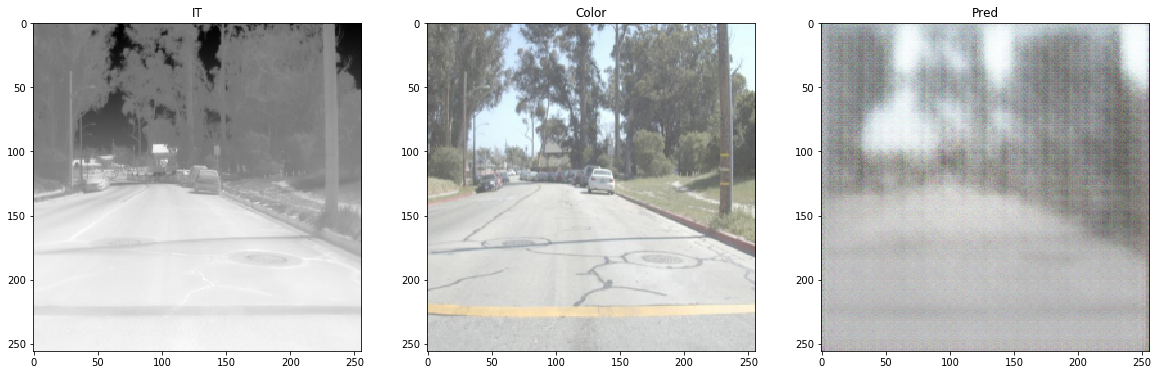

In [94]:
i = 4
xi = plot_sample(X_train, y_train, g_model, i)

In [88]:
g_model.load_weights('g_model_l1_best-salt.h5')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1014/1064,random_state=2019)

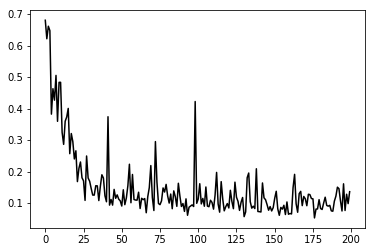

In [70]:
#plt.plot(g1)
#plt.plot(g2)
plt.plot(g3)
#plt.plot(d1)
#plt.plot(d2)
plt.show()